In [158]:
# Установка необходимых библиотек (выполнить один раз)
!pip install networkx  # Для работы с графами (требуется skfuzzy)
!pip install scikit-fuzzy  # Для нечеткой логики

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [159]:
# Импорт библиотек
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# ---------------------------
# 1. Определение универсумов
# ---------------------------
x_price = np.linspace(0, 150000, 150)
x_needs = np.linspace(0, 10, 100)      
x_comp = np.linspace(0, 100, 100)        
x_score = np.linspace(0, 100, 100)


In [160]:
# ---------------------------
# 2. Функции принадлежности
# ---------------------------

# Цена
price_lo = fuzz.trapmf(x_price, [0, 0, 30000, 50000])     # Бюджетная
price_md = fuzz.trapmf(x_price, [40000, 60000, 80000, 100000])  # Средняя
price_hi = fuzz.trapmf(x_price, [90000, 100000, 150000, 150000])  # Дорогая

# Потребности
needs_lo = fuzz.trapmf(x_needs, [0, 0, 3, 4])     # Офисные
needs_md = fuzz.trapmf(x_needs, [3, 4, 6.5, 7.5])     # Игровые
needs_hi = fuzz.trapmf(x_needs, [7, 7.5, 10, 10])   # Профессиональные

# Совместимость
comp_lo = fuzz.trapmf(x_comp, [0, 0, 40, 60])     # Низкая: 0-60%
comp_md = fuzz.trapmf(x_comp, [50, 60, 80, 90])  # Средняя: 40-80%
comp_hi = fuzz.trapmf(x_comp, [60, 80, 100, 100]) # Высокая: 60-100%

# Оценка сборки
score_lo = fuzz.trapmf(x_score, [0, 0, 40, 50])    # Плохо
score_md = fuzz.trapmf(x_score, [50, 60, 80, 90])      # Нормально
score_hi = fuzz.trapmf(x_score, [80, 90, 100, 100]) # Отлично

In [161]:
# ---------------------------
# 3. Расчет оценки через агрегирование
# ---------------------------
def calculate_score(price_val, needs_val, comp_val):
    # Фаззификация входных значений
    price_act_lo = fuzz.interp_membership(x_price, price_lo, price_val)
    price_act_md = fuzz.interp_membership(x_price, price_md, price_val)
    price_act_hi = fuzz.interp_membership(x_price, price_hi, price_val)
    
    needs_act_lo = fuzz.interp_membership(x_needs, needs_lo, needs_val)
    needs_act_md = fuzz.interp_membership(x_needs, needs_md, needs_val)
    needs_act_hi = fuzz.interp_membership(x_needs, needs_hi, needs_val)
    
    comp_act_lo = fuzz.interp_membership(x_comp, comp_lo, comp_val)
    comp_act_md = fuzz.interp_membership(x_comp, comp_md, comp_val)
    comp_act_hi = fuzz.interp_membership(x_comp, comp_hi, comp_val)

    # Правила для "Отлично"
    rule1 = np.fmin(price_act_lo, np.fmin(needs_act_lo, comp_act_hi))
    rule2 = np.fmin(price_act_md, np.fmin(needs_act_md, comp_act_hi))
    rule3 = np.fmin(price_act_hi, np.fmin(needs_act_hi, comp_act_hi))
    
    # Правила для "Нормально"
    rule4 = np.fmin(price_act_lo, np.fmin(needs_act_md, comp_act_hi))
    rule5 = np.fmin(price_act_lo, np.fmin(needs_act_lo, comp_act_md))
    rule6 = np.fmin(price_act_md, np.fmin(needs_act_lo, comp_act_hi))
    rule7 = np.fmin(price_act_md, np.fmin(needs_act_md, comp_act_md))
    rule8 = np.fmin(price_act_hi, np.fmin(needs_act_md, comp_act_hi))
    rule9 = np.fmin(price_act_hi, np.fmin(needs_act_hi, comp_act_md))
    rule10 = np.fmin(price_act_md, np.fmin(needs_act_hi, comp_act_hi))
    
    # Активация выходных функций
    activation_hi = np.fmax(np.fmax(rule1, rule2), rule3) * 1.5  # Объединяем правила для "Отлично"
    activation_md = np.fmax(
        np.fmax(np.fmax(rule4, rule5), np.fmax(rule6, rule7)),
        np.fmax(np.fmax(rule8, rule9), rule10)
    ) * 1.5  # Объединяем правила для "Нормально"

    # Все остальные случаи → "Плохо"
    activation_lo = np.ones_like(x_score)  # Базовый уровень активации для "Плохо"
    activation_lo = np.fmin(activation_lo, 1 - np.fmax(activation_hi, activation_md))  # Инвертируем логику

    # Агрегируем
    aggregated = np.fmax(
        np.fmin(activation_lo, score_lo),
        np.fmax(
            np.fmin(activation_md, score_md),
            np.fmin(activation_hi, score_hi)
        )
    )

    # Дефаззификация
    if np.max(aggregated) == 0:
        return 0.0  # Минимальная оценка, если все правила провалились
    return fuzz.defuzz(x_score, aggregated, 'centroid')

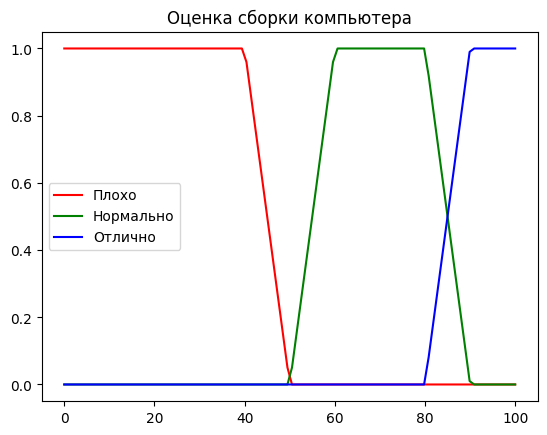

In [162]:
# ---------------------------
# 4. Визуализация
# ---------------------------
fig, ax = plt.subplots()
ax.plot(x_score, score_lo, 'r', label='Плохо')
ax.plot(x_score, score_md, 'g', label='Нормально')
ax.plot(x_score, score_hi, 'b', label='Отлично')
ax.legend()
plt.title("Оценка сборки компьютера")
plt.show()

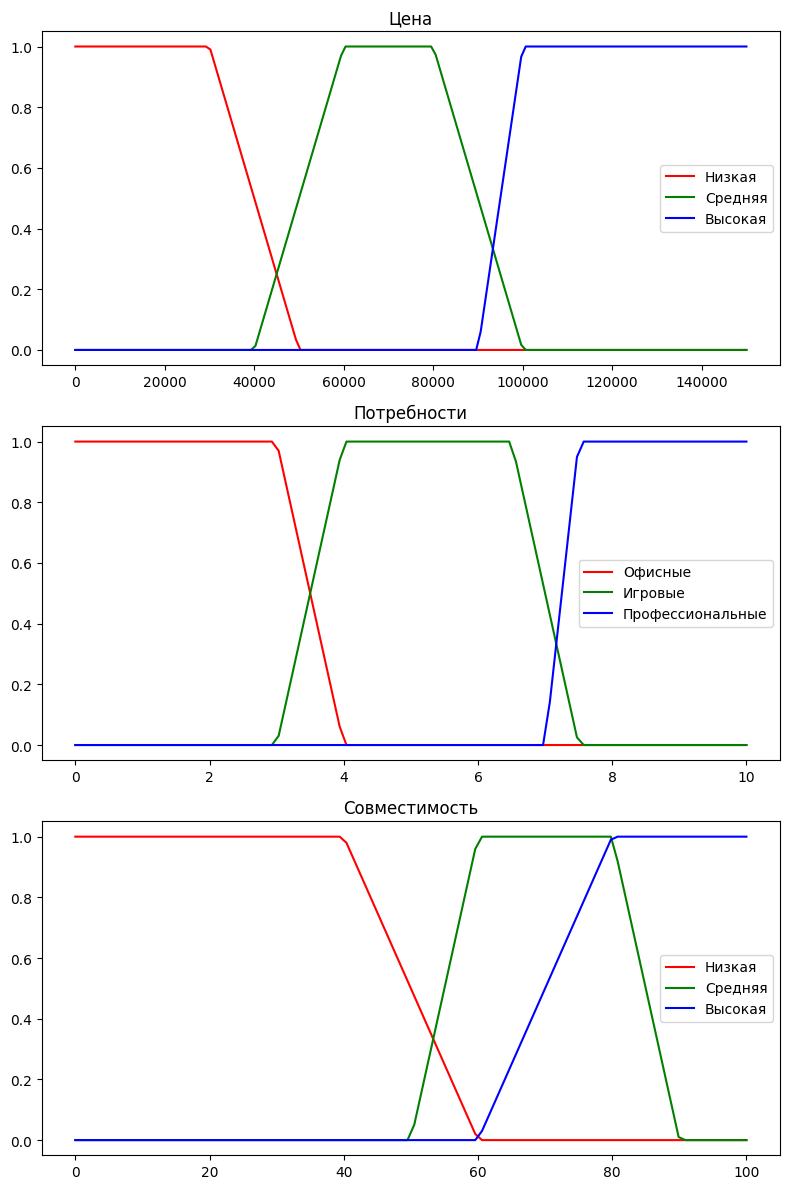

In [163]:
# Визуализация функций принадлежности для входных переменных
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Цена
ax1.plot(x_price, price_lo, 'r', label='Низкая')
ax1.plot(x_price, price_md, 'g', label='Средняя')
ax1.plot(x_price, price_hi, 'b', label='Высокая')
ax1.set_title("Цена")
ax1.legend()

# Потребности
ax2.plot(x_needs, needs_lo, 'r', label='Офисные')
ax2.plot(x_needs, needs_md, 'g', label='Игровые')
ax2.plot(x_needs, needs_hi, 'b', label='Профессиональные')
ax2.set_title("Потребности")
ax2.legend()

# Совместимость
ax3.plot(x_comp, comp_lo, 'r', label='Низкая')
ax3.plot(x_comp, comp_md, 'g', label='Средняя')
ax3.plot(x_comp, comp_hi, 'b', label='Высокая')
ax3.set_title("Совместимость")
ax3.legend()

plt.tight_layout()
plt.show()

In [174]:
# ---------------------------
# 5. Тестирование
# ---------------------------
import random

for _ in range(5):
    price = random.randint(20000, 150000)
    needs = random.randint(0, 10)
    comp = random.randint(40, 100)
    print(f"Цена: {price}₽, Потребности: {needs}, Совместимость: {comp}%")
    print(f"→ Оценка: {calculate_score(price, needs, comp):.1f}%")

Цена: 53644₽, Потребности: 10, Совместимость: 51%
→ Оценка: 22.6%
Цена: 127201₽, Потребности: 9, Совместимость: 64%
→ Оценка: 72.5%
Цена: 51833₽, Потребности: 0, Совместимость: 95%
→ Оценка: 62.4%
Цена: 141670₽, Потребности: 3, Совместимость: 95%
→ Оценка: 24.0%
Цена: 102912₽, Потребности: 1, Совместимость: 80%
→ Оценка: 22.6%
